<a href="https://colab.research.google.com/github/fsafarkhani/Customer-Churn-Prediction-/blob/main/Customer_Churn_Prediction_with_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Step 1: Setting Up the Environment

In [20]:
!pip install pandas numpy scikit-learn xgboost shap seaborn matplotlib


#Once installed, we import all the necessary libraries. These include data handling (Pandas, NumPy), visualization (Matplotlib, Seaborn), machine learning (Scikit-Learn, XGBoost), and feature analysis (SHAP).


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report


# Step 2: Uploading and Loading the Dataset
https://archive.ics.uci.edu/dataset/563/iranian+churn+dataset

In [22]:
from google.colab import files
uploaded = files.upload()

# Extracting the file name and reading it
file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name)

# Let's take a quick look at the dataset
print("Dataset Sample:\n", df.head())


Saving Customer Churn.csv to Customer Churn (1).csv
Dataset Sample:
    Call  Failure  Complains  Subscription  Length  Charge  Amount  \
0              8          0                    38               0   
1              0          0                    39               0   
2             10          0                    37               0   
3             10          0                    38               0   
4              3          0                    38               0   

   Seconds of Use  Frequency of use  Frequency of SMS  \
0            4370                71                 5   
1             318                 5                 7   
2            2453                60               359   
3            4198                66                 1   
4            2393                58                 2   

   Distinct Called Numbers  Age Group  Tariff Plan  Status  Age  \
0                       17          3            1       1   30   
1                        4          2  

#Step 3: Cleaning and Preprocessing the Data

In [23]:
print("\nMissing Values:\n", df.isnull().sum())



Missing Values:
 Call  Failure              0
Complains                  0
Subscription  Length       0
Charge  Amount             0
Seconds of Use             0
Frequency of use           0
Frequency of SMS           0
Distinct Called Numbers    0
Age Group                  0
Tariff Plan                0
Status                     0
Age                        0
Customer Value             0
Churn                      0
dtype: int64


#If there are missing values, we fill them with the median value of each column

In [24]:
df.fillna(df.median(), inplace=True)


#Converting Categorical Data

In [25]:
categorical_columns = ['Tariff Plan', 'Status', 'Age Group']  # Add more if needed
for col in categorical_columns:
    df[col] = LabelEncoder().fit_transform(df[col])


#Defining Features and Target Variable


In [26]:
X = df.drop(columns=['Churn'])
y = df['Churn']


#Since SHAP analysis later requires raw (unscaled) data, we create a copy of the feature set before scaling it:


In [27]:
X_unscaled = X.copy()


#Scaling Numerical Features

In [28]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Splitting the Dataset

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


#Step 4: Feature Selection with SHAP & Correlation

In [30]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

#extract feature importance and display the results in a sorted orde

In [31]:
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': rf_model.feature_importances_})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

print("\nFeature Importance (Random Forest):\n", feature_importance)



Feature Importance (Random Forest):
                     Feature  Importance
1                 Complains    0.186999
4            Seconds of Use    0.134006
2      Subscription  Length    0.125800
10                   Status    0.117984
5          Frequency of use    0.110226
12           Customer Value    0.070298
7   Distinct Called Numbers    0.068556
0             Call  Failure    0.065217
6          Frequency of SMS    0.051038
8                 Age Group    0.029075
11                      Age    0.025486
3            Charge  Amount    0.014141
9               Tariff Plan    0.001173


#Visualizing Feature Importance

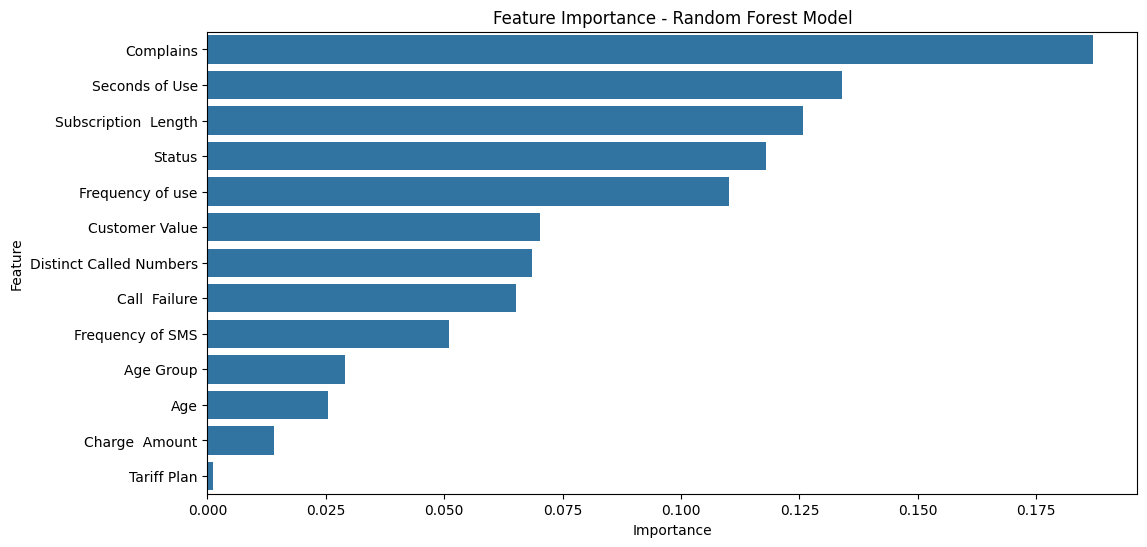

In [32]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance - Random Forest Model')
plt.show()


#SHAP Analysis for Deeper Insights

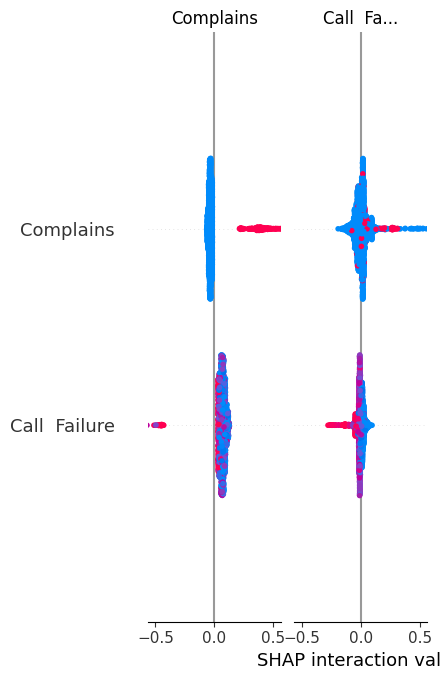

In [33]:
rf_explainer = shap.TreeExplainer(rf_model)
shap_values = rf_explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train, feature_names=X.columns)


#Step 5: Model Training & Evaluation

In [34]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

}


#we train it on the training set, make predictions, and evaluate the results:

In [35]:
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    results.append([name, accuracy, precision, recall, f1, roc_auc])

    print(f"\n{name} Model Performance:")
    print(classification_report(y_test, y_pred))



Logistic Regression Model Performance:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       520
           1       0.73      0.40      0.52       110

    accuracy                           0.87       630
   macro avg       0.81      0.68      0.72       630
weighted avg       0.86      0.87      0.85       630


Decision Tree Model Performance:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       520
           1       0.82      0.79      0.81       110

    accuracy                           0.93       630
   macro avg       0.89      0.88      0.88       630
weighted avg       0.93      0.93      0.93       630


Random Forest Model Performance:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       520
           1       0.84      0.75      0.79       110

    accuracy                           0.93       630
   macro avg       0

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:37:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


#store all the results in a DataFrame for easy comparison

In [36]:
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC'])
print("\nModel Performance Comparison:\n", results_df)



Model Performance Comparison:
                  Model  Accuracy  Precision    Recall  F1 Score   ROC-AUC
0  Logistic Regression  0.869841   0.733333  0.400000  0.517647  0.684615
1        Decision Tree  0.933333   0.820755  0.790909  0.805556  0.877185
2        Random Forest  0.931746   0.838384  0.754545  0.794258  0.861888
3              XGBoost  0.944444   0.878788  0.790909  0.832536  0.883916


#Step 6: Feature Importance with XGBoost


In [37]:
xgb_model = xgb.XGBClassifier(eval_metric='logloss', verbosity=0)

xgb_model.fit(X_train, y_train)

xgb_feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': xgb_model.feature_importances_})
xgb_feature_importance = xgb_feature_importance.sort_values(by='Importance', ascending=False)


#plot the results:

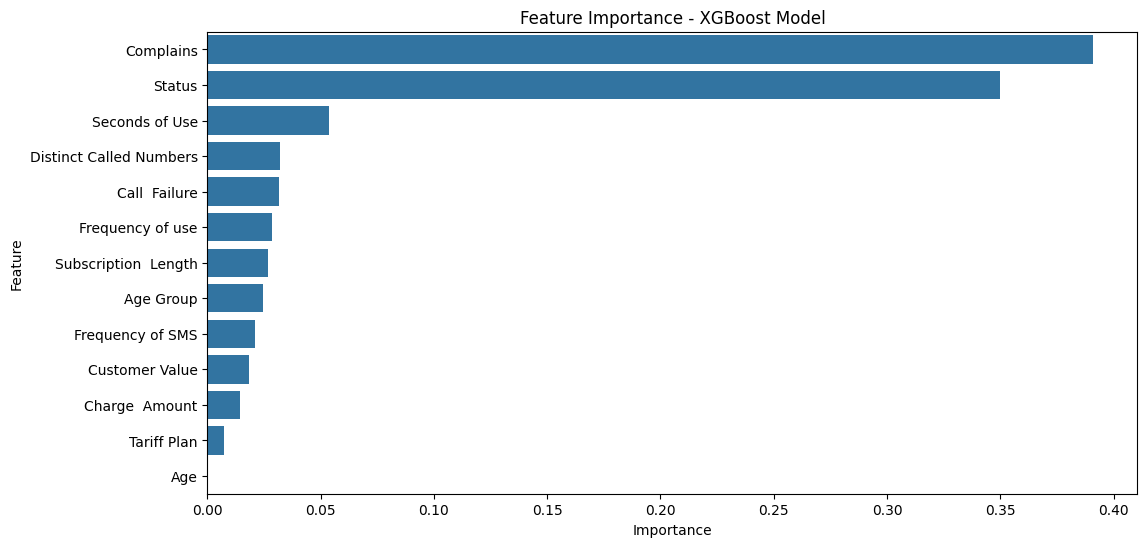

In [38]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=xgb_feature_importance)
plt.title('Feature Importance - XGBoost Model')
plt.show()
